In [1]:
from __future__ import absolute_import, division, print_function

import os
import random
import numpy as np
import copy
from PIL import Image  

import PIL.Image as pil
from tqdm import tqdm
import torch
import torch.utils.data as data
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import skimage.transform
from collections import Counter
import time

import json

from utils import *
from kitti_utils import *
from layers import *
from Encoder import *
from depthDecoder import *

import datasets
import networks
from IPython import embed
cuda = torch.cuda.is_available()
cuda

True

In [2]:
dataset = datasets.KITTIRAWDataset 
data_path = "/home/ubuntu/monodepth2/kitti_data"
fpath_train = "/home/ubuntu/monodepth2/splits/eigen_zhou/train_files.txt"
f_train = open(fpath_train)
train_filenames = f_train.readlines()
fpath_val = "/home/ubuntu/monodepth2/splits/eigen_zhou/val_files.txt"
f_val = open(fpath_val)
val_filenames = f_val.readlines()

In [3]:
height = 192
width = 640
scales = np.arange(4)
img_ext = '.jpg'
device = torch.device("cuda" if cuda else "cpu")
frame_ids = [0,'s']
weights_init = 'pretrained'
num_scales = len(scales)
num_input_frames = len(frame_ids)
num_layers = 18
learning_rate = 0.0001

In [4]:
batch_size = 32
num_workers = 12

train_dataset = dataset(data_path, train_filenames, height, width,frame_ids,num_scales,is_train=True, img_ext=img_ext)
train_loader = DataLoader(train_dataset, batch_size, True,num_workers=num_workers, pin_memory=True, drop_last=True)

val_dataset = dataset(data_path, val_filenames, height, width,frame_ids, 4, is_train=False, img_ext=img_ext)
val_loader = DataLoader(val_dataset, batch_size, True,num_workers=num_workers, pin_memory=True, drop_last=True)

In [5]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight.data)
    elif type(m) == nn.BatchNorm2d:
        #nn.init.constant_(m.weight, 1)
        nn.init.normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias, 0)

In [6]:
params = []
#encoder = networks.ResnetEncoder(num_layers, weights_init == "pretrained")
encoder = ResnetEncoder()
encoder.apply(init_weights)
params += list(encoder.parameters())

#decoder = networks.DepthDecoder(encoder.num_ch_enc, scales)
decoder = Decoder(encoder.num_ch_enc, scales)
decoder.apply(init_weights)
params += list(decoder.parameters())
ssim = SSIM()
ssim.to(device)

encoder.to(device)
decoder.to(device)
optimizer = optim.Adam(params, learning_rate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 15, 0.1)

In [7]:
backproject_depth = {}
project_3d = {}
for scale in scales:
    h = height // (2 ** scale)
    w = width // (2 ** scale)

    backproject_depth[scale] = BackprojectDepth(batch_size, h, w)
    backproject_depth[scale].to(device)

    project_3d[scale] = Project3D(batch_size, h, w)
    project_3d[scale].to(device)
print("There are {:d} training items and {:d} validation items\n".format(len(train_dataset), len(val_dataset)))

There are 39810 training items and 4424 validation items



In [9]:
def generate_images_pred(inputs, outputs):
        
    frame_id = 's'
    source_scale = 0
    
    for scale in scales:
        disp = outputs[("disp", scale)]

        disp = F.interpolate(disp, [height, width], mode="bilinear",align_corners=False)
        
        depth = 1 / (0.01 + 9.99*disp)
 
        outputs[("depth", 0, scale)] = depth

        T = inputs["stereo_T"]

        cam_points = backproject_depth[source_scale](depth, inputs[("inv_K", source_scale)])
        pix_coords = project_3d[source_scale](cam_points, inputs[("K", source_scale)], T)
        outputs[("color", frame_id, scale)] = F.grid_sample(inputs[("color", frame_id, source_scale)],
                pix_coords,
                padding_mode="border",align_corners=False)

    return outputs             

In [8]:
def compute_reprojection_loss(pred, target):

        l1_loss = (torch.abs(target - pred)).mean(1,True)
        
        #reprojection_loss = l1_loss

        ssim_loss = ssim(pred, target).mean(1, True)
        reprojection_loss = 0.85 * ssim_loss + 0.15 * l1_loss

        return reprojection_loss

In [22]:
def get_smooth_loss(disp, img):

    grad_disp_x = torch.abs(disp[:, :, :, :-1] - disp[:, :, :, 1:])
    grad_disp_y = torch.abs(disp[:, :, :-1, :] - disp[:, :, 1:, :])

    grad_img_x = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]), 1, keepdim=True)
    grad_img_y = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]), 1, keepdim=True)

    grad_disp_x *= torch.exp(-grad_img_x)
    grad_disp_y *= torch.exp(-grad_img_y)

    return grad_disp_x.mean() + grad_disp_y.mean()


In [10]:
def compute_losses(inputs, outputs):

        losses = {}
        total_loss = 0
        frame_id = 's'

        for scale in scales:
            loss = 0
            reprojection_losses = []

            source_scale = 0

            disp = outputs[("disp", scale)]
            color = inputs[("color", 0, scale)]
            target = inputs[("color", 0, source_scale)]


            pred = outputs[("color", frame_id, scale)]
            reprojection_losses.append(compute_reprojection_loss(pred, target))

            reprojection_losses = torch.cat(reprojection_losses, 1)
            to_optimise = reprojection_losses
            loss = loss + to_optimise.mean()

            norm_disp = disp / (disp.mean(2, True).mean(3, True)+ 1e-7)
            smooth_loss = get_smooth_loss(norm_disp, color)

            loss =  loss + ((1e-3)*smooth_loss) / (2 ** scale)
            total_loss = total_loss + loss
            losses["loss/{}".format(scale)] = loss

        total_loss = total_loss/num_scales
        losses["loss"] = total_loss
        return losses

In [11]:
def compute_depth_losses(inputs, outputs, losses):


        depth_pred = outputs[("depth", 0, 0)]
        depth_pred = torch.clamp(F.interpolate(
            depth_pred, [375, 1242], mode="bilinear", align_corners=False), min=1e-3, max=80)
        depth_pred = depth_pred.detach()

        depth_gt = inputs["depth_gt"]
        mask = depth_gt > 0

        crop_mask = torch.zeros_like(mask)
        crop_mask[:, :, 153:371, 44:1197] = 1
        mask = mask * crop_mask

        gt = depth_gt[mask]
        pred = depth_pred[mask]
        pred = pred*(torch.median(gt) / torch.median(pred))

        pred = torch.clamp(pred, min=1e-3, max=80)
        thresh = torch.max((gt / pred), (pred / gt))
        a1 = (thresh < 1.25     ).float().mean()
        a2 = (thresh < 1.25 ** 2).float().mean()
        a3 = (thresh < 1.25 ** 3).float().mean()

        rmse = torch.sqrt(((gt - pred)**2).mean())
        rmse_log = torch.sqrt(((torch.log(gt) - torch.log(pred))**2).mean())
        abs_rel = torch.mean(torch.abs(gt - pred) / gt)
        sq_rel = torch.mean(((gt - pred)**2 )/ gt)
        
        return np.array([abs_rel.item(),sq_rel.item(),rmse.item(),rmse_log.item(),a1.item(),a2.item(),a3.item()])


In [25]:
def train(encoder,decoder,train_loader,val_loader,num_epochs):
              
        encoder.train()
        decoder.train()
        for epoch in range(num_epochs):

            total_loss = 0 
            outer = tqdm(total=(len(train_loader)), desc='Training Epoch', position=0)

            for batch_idx, inputs in enumerate(train_loader):
                outer.update(1)
                optimizer.zero_grad()


                for key, ipt in inputs.items():
                    inputs[key] = ipt.to(device)

                features = encoder(inputs["color_aug", 0, 0])
                outputs = decoder(features)
       
                outputs = generate_images_pred(inputs, outputs)
                
                losses = compute_losses(inputs, outputs)
                total_loss = total_loss + losses['loss'].item()
                optimizer.zero_grad()
                losses["loss"].backward()
                optimizer.step()
                lr_scheduler.step()

                del inputs, outputs, losses,features
                if batch_idx%100==0 and batch_idx>0:
                    print('Batch No: ',batch_idx)
                    print('Loss: ',total_loss/(batch_idx+1))
  
            total_loss = total_loss/len(train_loader)
            print('Train Loss at Epoch_{}:'.format(epoch+1),total_loss)
            validation(encoder,decoder,val_loader)

In [14]:
def validation(encoder,decoder,val_loader):
    
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        total_loss = 0
        metrics = np.zeros((7))
        for batch_idx, inputs in enumerate(val_loader):

            before_op_time = time.time()

            for key, ipt in inputs.items():
                inputs[key] = ipt.to(device)

            features = encoder(inputs["color_aug", 0, 0])
            outputs = decoder(features)
            outputs = generate_images_pred(inputs, outputs)
            losses = compute_losses(inputs, outputs)
            total_loss = total_loss + losses['loss'].item()
         
            metrics = metrics + compute_depth_losses(inputs, outputs, losses)
            del inputs, outputs, losses,features
         
        total_loss = total_loss/len(val_loader)
        print('Total Loss (Validation): ',total_loss)
        print('Error Metrics: ',metrics/len(val_loader))      

In [15]:
num_epochs = 1
train(encoder,decoder,train_loader,val_loader,num_epochs)

Training Epoch:   1%|          | 14/1244 [01:15<1:49:36,  5.35s/it]

KeyboardInterrupt: 

In [13]:
i = 0
total_loss = 0
for batch_idx, inputs in enumerate(train_loader):
                optimizer.zero_grad()

                for key, ipt in inputs.items():
                    inputs[key] = ipt.to(device)

                features = encoder(inputs["color_aug", 0, 0])
                outputs = decoder(features)
               
                o1 = generate_images_pred(inputs, outputs)
                
                losses = compute_losses(inputs, o1)
                
                total_loss = total_loss + losses['loss'].item()
                optimizer.zero_grad()
                losses["loss"].backward()
                optimizer.step()
                i = i+1
                
                lr_scheduler.step()
                
                if i>2:
                    break
                   
                del inputs, outputs, losses,features
                

In [15]:
outputs[('disp', 3)]

tensor([[[[2.6774e-22, 3.7136e-22, 5.4084e-22,  ..., 1.8825e-20,
           7.6532e-21, 2.5834e-20],
          [2.6878e-22, 5.3270e-22, 5.8902e-22,  ..., 2.5858e-20,
           1.1879e-20, 3.7457e-20],
          [2.7763e-22, 3.2711e-22, 5.4084e-22,  ..., 3.4518e-20,
           6.1803e-20, 3.8419e-20],
          ...,
          [5.4686e-23, 4.9844e-23, 8.8097e-23,  ..., 3.4740e-19,
           1.2167e-19, 1.6638e-19],
          [4.9813e-23, 5.4179e-23, 9.2155e-23,  ..., 9.1332e-20,
           2.5296e-19, 1.3251e-19],
          [5.3205e-23, 6.8829e-23, 1.0410e-22,  ..., 4.1000e-19,
           5.1240e-19, 6.1852e-19]]],


        [[[1.6485e-21, 1.6513e-22, 3.0550e-22,  ..., 3.8301e-22,
           2.9390e-22, 5.1325e-22],
          [1.4153e-21, 9.7536e-23, 3.0786e-22,  ..., 3.0174e-22,
           2.2566e-22, 4.1051e-22],
          [4.2399e-21, 2.6101e-22, 1.0406e-21,  ..., 2.4909e-22,
           1.7737e-22, 3.5151e-22],
          ...,
          [1.8823e-22, 3.7895e-22, 9.7455e-23,  ..., 7.64

In [16]:
image_path = "/home/ubuntu/monodepth2/assets/test_image.jpg"
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
input_image_resized = input_image.resize((width, height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [17]:
with torch.no_grad():
    encoder.eval()
    decoder.eval()
    features = encoder(input_image_pytorch.to(device))
    outputs = decoder(features)

disp = outputs[("disp", 0)]

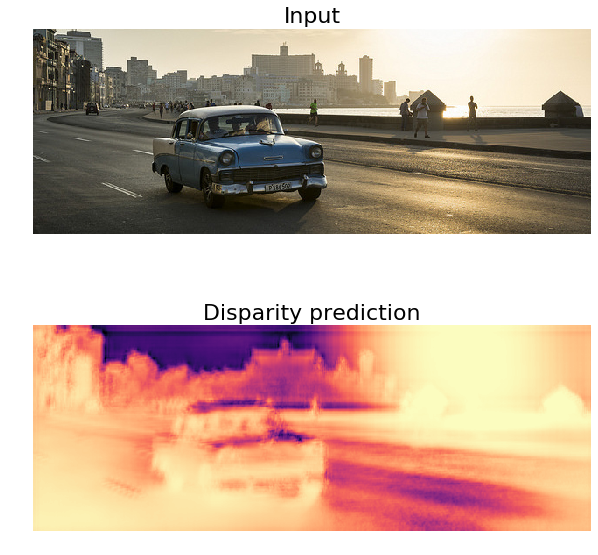

In [19]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=True)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [18]:
disp

tensor([[[[0.9997, 0.9997, 0.9997,  ..., 0.9998, 0.9998, 0.9998],
          [0.9997, 0.9997, 0.9997,  ..., 0.9998, 0.9998, 0.9998],
          [0.9997, 0.9997, 0.9997,  ..., 0.9998, 0.9998, 0.9998],
          ...,
          [0.9999, 0.9999, 0.9999,  ..., 0.9998, 0.9998, 0.9998],
          [0.9999, 0.9999, 0.9999,  ..., 0.9998, 0.9998, 0.9998],
          [0.9999, 0.9999, 0.9999,  ..., 0.9998, 0.9998, 0.9998]]]],
       device='cuda:0')